In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
df = pd.read_csv('./dataset/no_date_set.csv')

In [20]:
df.columns

Index(['max_temperature_f', 'mean_temperature_f', 'min_temperature_f',
       'max_dew_point_f', 'mean_dew_point_f', 'min_dew_point_f',
       'max_humidity', 'mean_humidity', 'min_humidity',
       'max_sea_level_pressure_inches', 'mean_sea_level_pressure_inches',
       'min_sea_level_pressure_inches', 'max_visibility_miles',
       'mean_visibility_miles', 'min_visibility_miles', 'max_wind_Speed_mph',
       'mean_wind_speed_mph', 'max_gust_speed_mph', 'cloud_cover',
       'trip_count', 'isRain', 'isFog', 'isThunderstorm', 'zip_code_94041',
       'zip_code_94063', 'zip_code_94107', 'zip_code_94301', 'zip_code_95113',
       'Weekday_Friday', 'Weekday_Monday', 'Weekday_Saturday',
       'Weekday_Sunday', 'Weekday_Thursday', 'Weekday_Tuesday',
       'Weekday_Wednesday', 'Holiday_Christmas Day', 'Holiday_Columbus Day',
       'Holiday_Independence Day', 'Holiday_Independence Day (Observed)',
       'Holiday_Labor Day', 'Holiday_Martin Luther King, Jr. Day',
       'Holiday_Memorial 

Let's take a glance at the data.

In [23]:
df = df[df["zip_code_94107"]== 1]

In both the following tutorials, the first 300,000 rows of the data will be the training dataset, and there remaining will be the validation dataset. This amounts to ~2100 days worth of training data.

In [76]:
TARGETS = df['trip_count'].to_numpy()

In [77]:
TARGETS.shape

(1099,)

In [16]:
TRAIN_SPLIT = 800

Setting seed to ensure reproducibility.

In [4]:
tf.random.set_seed(13)

In [171]:
# Threashold 0.03 corr
features_considered = ['trip_count',
        'isRain', 'isFog', 'isThunderstorm',
       'Weekday_Friday', 'Weekday_Monday', 'Weekday_Saturday',
       'Weekday_Sunday', 'Weekday_Thursday', 'Weekday_Tuesday',
       'Weekday_Wednesday', 'Holiday_Christmas Day', 'Holiday_Columbus Day',
       'Holiday_Independence Day', 'Holiday_Independence Day (Observed)',
       'Holiday_Labor Day', 'Holiday_Martin Luther King, Jr. Day',
       'Holiday_Memorial Day', "Holiday_New Year's Day", 'Holiday_None',
       'Holiday_Thanksgiving', 'Holiday_Veterans Day',
       "Holiday_Washington's Birthday"]

In [172]:
features = df[features_considered]

features.columns

Index(['trip_count', 'isRain', 'isFog', 'isThunderstorm', 'Weekday_Friday',
       'Weekday_Monday', 'Weekday_Saturday', 'Weekday_Sunday',
       'Weekday_Thursday', 'Weekday_Tuesday', 'Weekday_Wednesday',
       'Holiday_Christmas Day', 'Holiday_Columbus Day',
       'Holiday_Independence Day', 'Holiday_Independence Day (Observed)',
       'Holiday_Labor Day', 'Holiday_Martin Luther King, Jr. Day',
       'Holiday_Memorial Day', 'Holiday_New Year's Day', 'Holiday_None',
       'Holiday_Thanksgiving', 'Holiday_Veterans Day',
       'Holiday_Washington's Birthday'],
      dtype='object')

Let's have a look at how each of these features vary across time.

As mentioned, the first step will be to normalize the dataset using the mean and standard deviation of the training data.

In [173]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [174]:
dataset = (dataset-data_mean)/data_std

### Multi-Step model
In a multi-step prediction model, given a past history, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predict a sequence of the future.

For the multi-step model, the training data again consists of recordings over the past five days sampled every hour. However, here, the model needs to learn to predict the temperature for the next 12 hours. Since an obversation is taken every 10 minutes, the output is 72 predictions. For this task, the dataset needs to be prepared accordingly, thus the first step is just to create it again, but with a different target window.

In [175]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [189]:
past_history = 60
STEP = 1
BUFFER_SIZE = 2000
BATCH_SIZE = 64
LABEL_IDX = 0

In [190]:
dataset[:,LABEL_IDX].reshape(-1,1).shape
single_var_df = dataset[:,LABEL_IDX].reshape(-1,1)

In [191]:
future_target = 14
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:,LABEL_IDX], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:,LABEL_IDX],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

Let's check out a sample data-point.

In [192]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (60, 23)

 Target temperature to predict : (14,)


In [193]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

Plotting a sample data-point.

In [194]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 0]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo', label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro', label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

In this plot and subsequent similar plots, the history and the future data are sampled every hour.

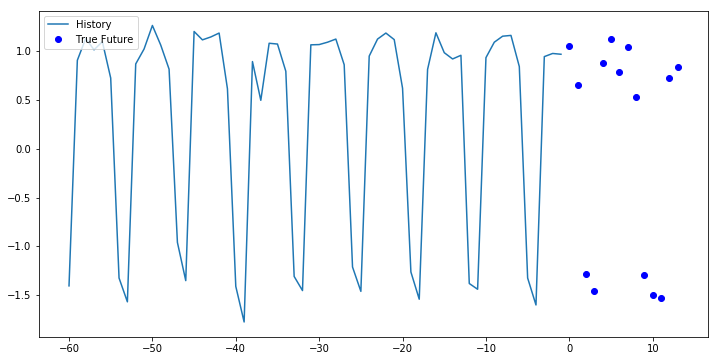

In [195]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

Since the task here is a bit more complicated than the previous task, the model now consists of two LSTM layers. Finally, since 72 predictions are made, the dense layer outputs 72 predictions.

In [196]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(future_target))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

Let's see how the model predicts before it trains.

In [197]:
for x, y in val_data_multi.take(1):
    print (multi_step_model.predict(x).shape)

(64, 14)


In [198]:
EVALUATION_INTERVAL = 200
EPOCHS = 20

In [199]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/20
200/200 [==============================] - 17s 85ms/step - loss: 0.7455 - val_loss: 0.5937
Epoch 2/20
200/200 [==============================] - 14s 72ms/step - loss: 0.4729 - val_loss: 0.3983
Epoch 3/20
200/200 [==============================] - 14s 72ms/step - loss: 0.3150 - val_loss: 0.3256
Epoch 4/20
200/200 [==============================] - 14s 71ms/step - loss: 0.2512 - val_loss: 0.3339
Epoch 5/20
200/200 [==============================] - 14s 72ms/step - loss: 0.2282 - val_loss: 0.2848
Epoch 6/20
200/200 [==============================] - 14s 72ms/step - loss: 0.2181 - val_loss: 0.3041
Epoch 7/20
200/200 [==============================] - 14s 72ms/step - loss: 0.2128 - val_loss: 0.3275
Epoch 8/20
200/200 [==============================] - 14s 72ms/step - loss: 0.2083 - val_loss: 0.3495
Epoch 9/20
200/200 [==============================] - 15s 73ms/step - loss: 0.2047 - val_loss: 0.3630
Epoch 10/20
200/200 [==================

In [200]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

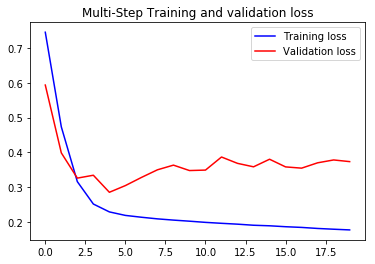

In [202]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

#### Predict a multi-step future
Let's now have a look at how well your network has learnt to predict the future.

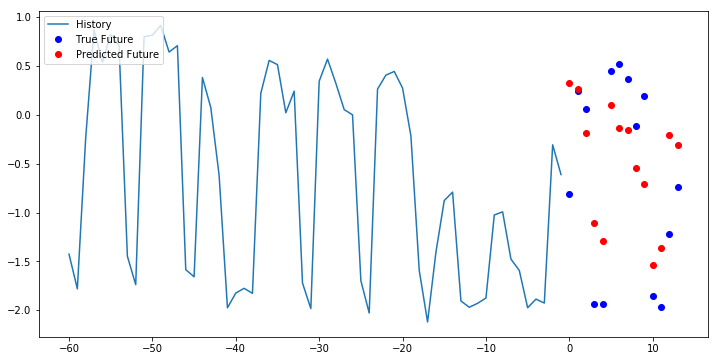

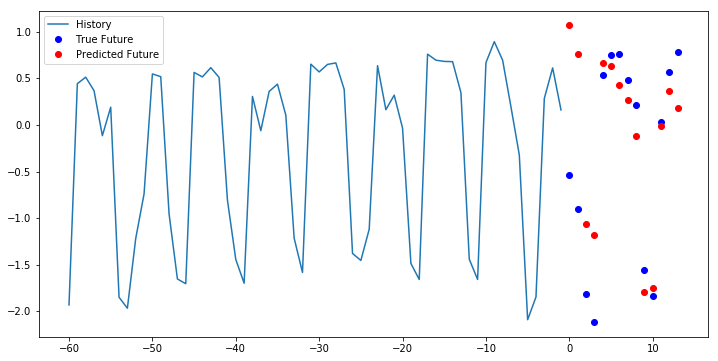

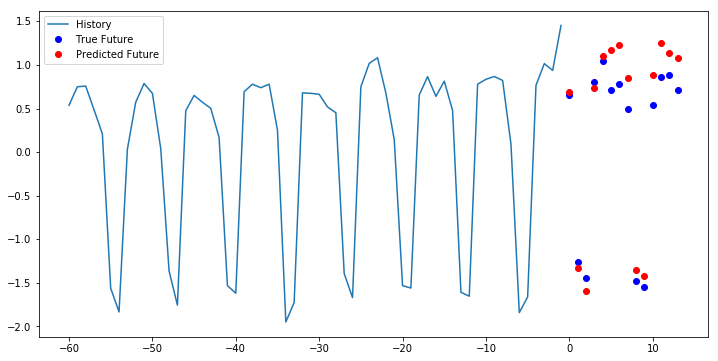

In [203]:
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

In [204]:
multi_step_model.save('LSTM-weatherevent-holiday.h5')